In [13]:
import pydem
import pydpmd as dp
from pydpmd.plot import draw_particles_frame
from pydpmd.utils import split_systems, join_systems
import taichi as ti
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os

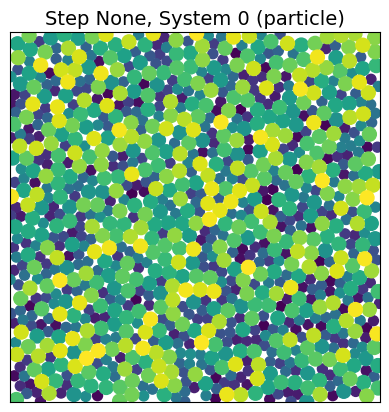

In [84]:
data = dp.data.load('/home/mmccraw/dev/data/10-06-25/jamming/disk/jamming_0', location=['final', 'init'])
draw_particles_frame(None, plt.gca(), data, 0, True, 'particle', 'viridis', 'final')

In [98]:
e_c = 1.0
temp = 1e-4
N_steps = 10000
dt = 1e-2
verlet_skin = 0.5

pos = ti.ndarray(dtype=pydem.vec2_float, shape=(data.n_particles(),))
pos.from_numpy(data.pos)

vel = ti.ndarray(dtype=pydem.vec2_float, shape=(data.n_particles(),))
vel.from_numpy(np.random.normal(loc=0, scale=np.sqrt(temp), size=(data.n_particles(), 2)))

force = ti.ndarray(dtype=pydem.vec2_float, shape=(data.n_particles(),))
force.from_numpy(data.force)

radii = ti.ndarray(dtype=pydem.dtype_float, shape=(data.n_particles(),))
radii.from_numpy(data.rad)

mass = ti.ndarray(dtype=pydem.dtype_float, shape=(data.n_particles(),))
mass.from_numpy(data.mass)

box_size = pydem.vec2_float(data.box_size[0, 0], data.box_size[0, 1])

last_pos = ti.ndarray(dtype=pydem.vec2_float, shape=(data.n_particles(),))
disp_sq = ti.ndarray(dtype=pydem.dtype_float, shape=(data.n_particles(),))
pe = ti.ndarray(dtype=pydem.dtype_float, shape=(data.n_particles(),))
ke = ti.ndarray(dtype=pydem.dtype_float, shape=(data.n_particles(),))

verlet_rad = (1 + verlet_skin) * 2 * np.max(radii.to_numpy())
verlet_thresh_sq = (verlet_skin / 2.0) ** 2
neigh_ids, neigh_offset = pydem.build_neighbors_naive(pos, verlet_rad, pydem.dist_pbc, box_size)
flag = ti.field(dtype=pydem.dtype_int, shape=())
last_pos.copy_from(pos)
disp_sq.fill(0)

pydem.scale_to_temperature(temp, vel, mass)

delta_phi = -0.01
phi = np.sum(np.pi * radii.to_numpy() ** 2) / np.prod(box_size.to_numpy())
phi = phi + delta_phi
new_box_size = np.sqrt(np.sum(np.pi * radii.to_numpy() ** 2) / (phi)) * np.ones_like(box_size.to_numpy())
new_box_size = pydem.vec2_float(new_box_size[0], new_box_size[1])
scale = new_box_size / box_size
box_size *= scale
pos.from_numpy(pos.to_numpy() * scale.to_numpy())


In [102]:
pos_hist = np.zeros((N_steps, pos.shape[0], 2))
vel_hist = np.zeros((N_steps, pos.shape[0], 2))
force_hist = np.zeros((N_steps, pos.shape[0], 2))
for i in range(N_steps):
    pydem.update_velocities(vel, force, mass, dt)
    pydem.update_positions(pos, last_pos, vel, disp_sq, dt)
    force.fill(0)
    pe.fill(0)
    pydem.compute_forces(pos, force, pe, radii, neigh_ids, neigh_offset, pydem.dist_pbc, box_size, pydem.soft_disk, e_c)
    pydem.update_velocities(vel, force, mass, dt)

    pos_hist[i] = pos.to_numpy()
    vel_hist[i] = vel.to_numpy()
    force_hist[i] = force.to_numpy()

    # update neighbors if needed
    pydem.any_exceeds(disp_sq, verlet_thresh_sq, flag)
    if bool(flag[None]):
        neigh_ids, neigh_offset = pydem.build_neighbors_naive(pos, verlet_rad, pydem.dist_pbc, box_size)
        last_pos.copy_from(pos)
        disp_sq.fill(0)

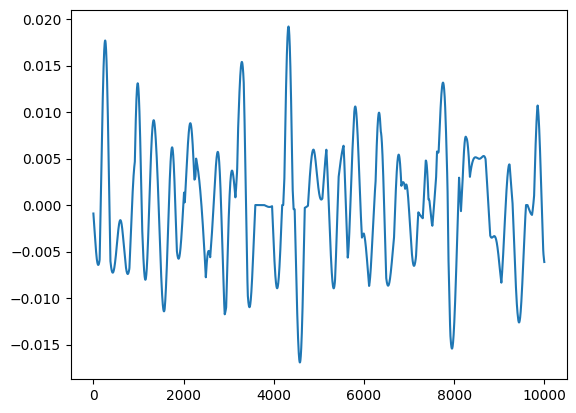

In [105]:
plt.plot(force_hist[:, 0, 1])